### Importation des bibliothèques 

In [10]:
from keras.preprocessing.image import load_img, img_to_array
import cv2
from PIL import Image
import numpy as np
import pytesseract
from pytesseract import Output
import tensorflow as tf
from resizeimage import resizeimage

### Digits Model

In [2]:
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)= mnist.load_data()

x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
model.add(tf.keras.layers.Dense(units=128,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(units=128,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(units=10,activation=tf.nn.softmax))

model.compile(optimizer="adam",loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
model.fit(x_train,y_train,epochs=3)

Epoch 1/3
60000/60000 [==============================] - 16s 269us/sample - loss: 0.2545 - acc: 0.9255
Epoch 2/3
60000/60000 [==============================] - 11s 189us/sample - loss: 0.1017 - acc: 0.9686
Epoch 3/3
60000/60000 [==============================] - 11s 185us/sample - loss: 0.0716 - acc: 0.9776


In [4]:
loss, accuracy = model.evaluate(x_test,y_test)
print("accuracy: ",accuracy)
print("loss: ",loss)

10000/10000 [==============================] - 1s 115us/sample - loss: 0.0938 - acc: 0.9711
accuracy:  0.9711
loss:  0.09382687661442905


### Prétraitement

In [5]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

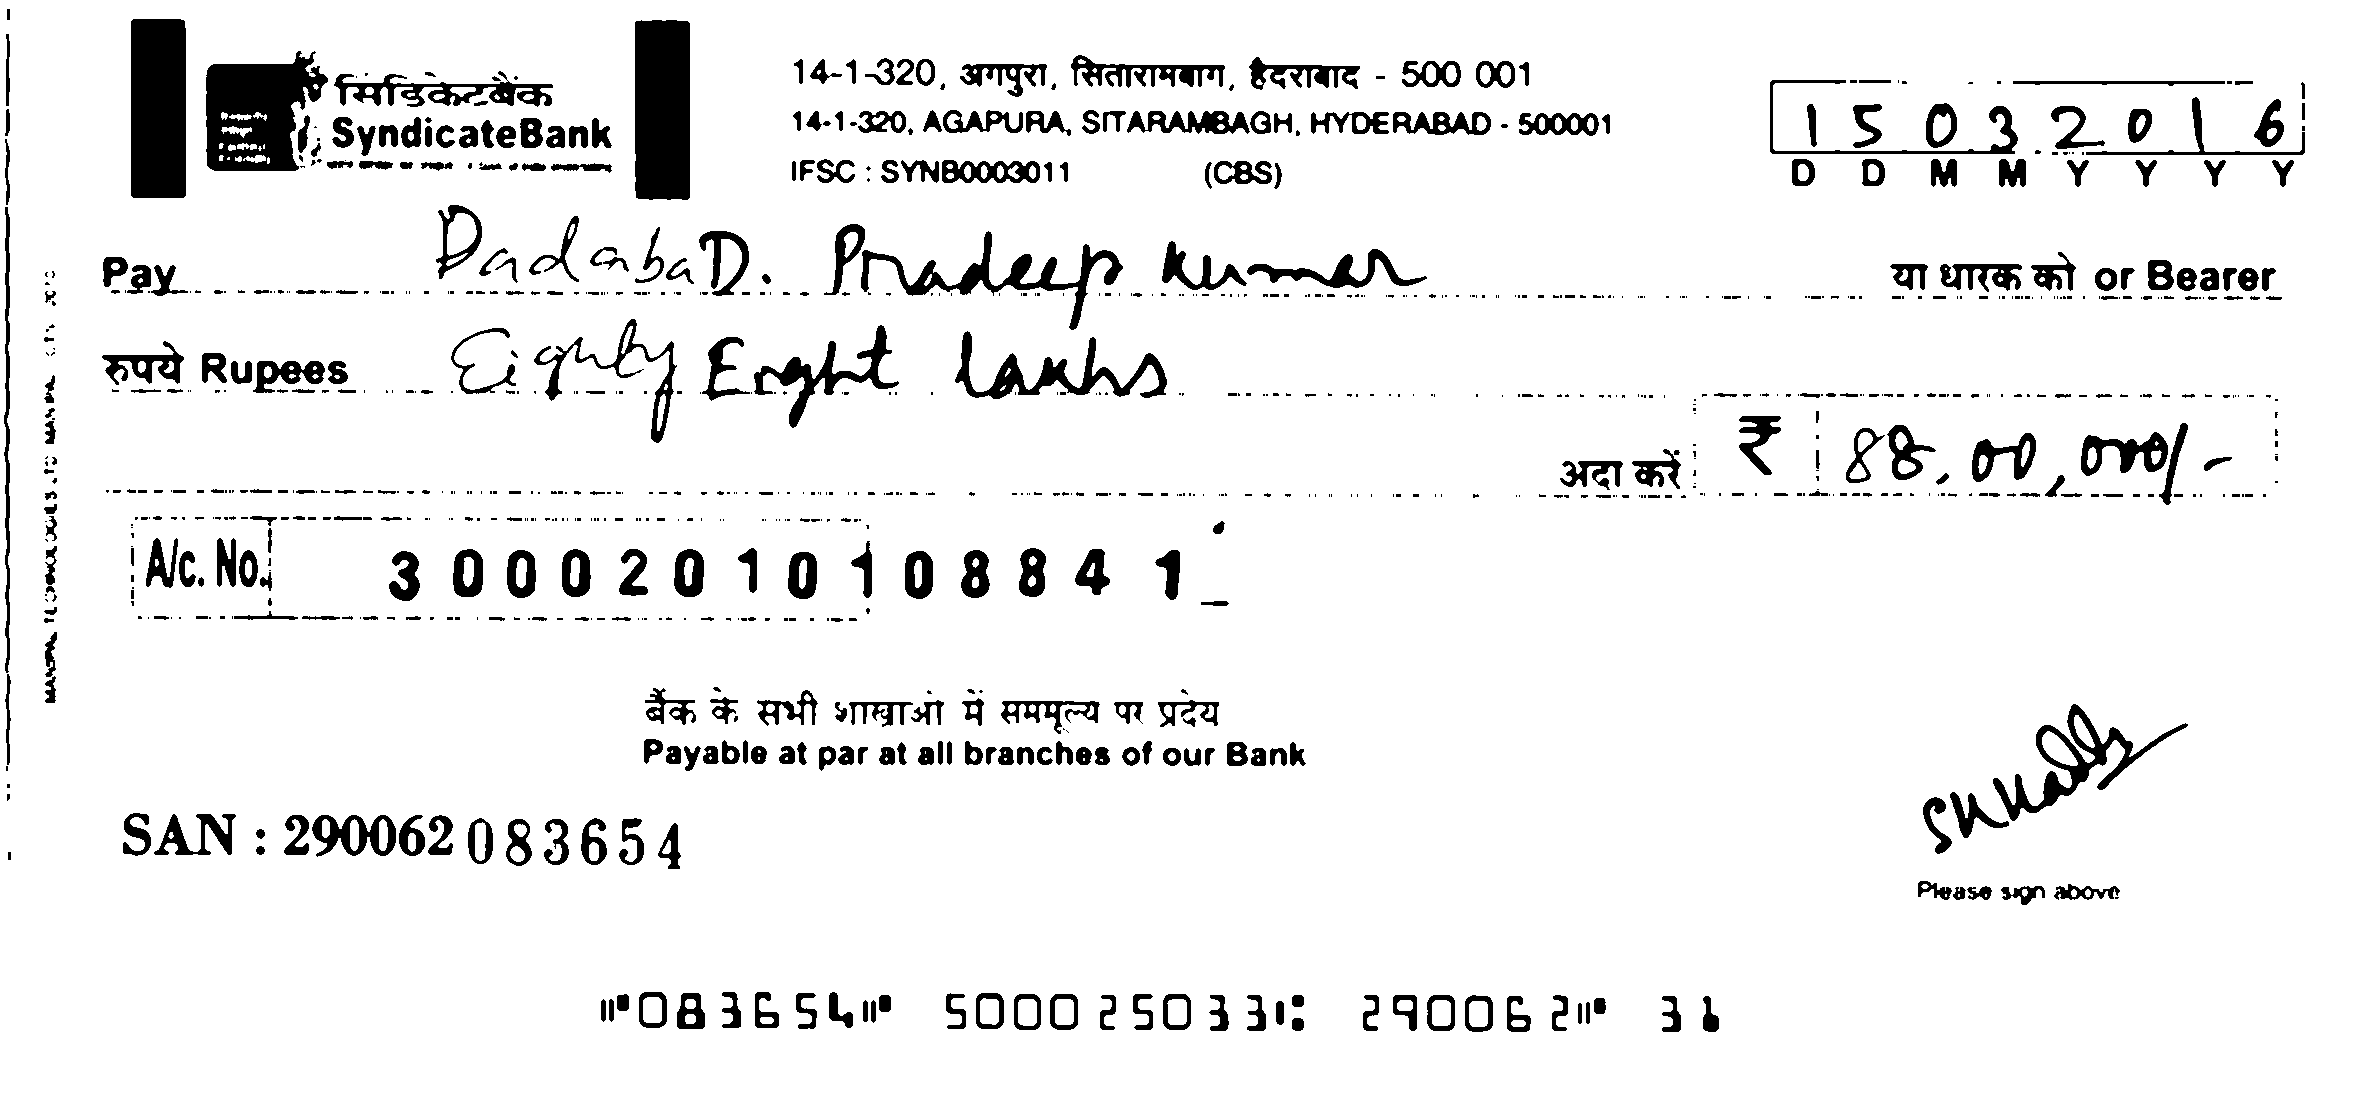

In [6]:
img = cv2.imread('Data/Cheque 083654.tif')
gray = get_grayscale(img)
r_noise = remove_noise(gray)
thresh = thresholding(r_noise)
Image.fromarray(thresh)

In [8]:
custom_config = r'--oem 3 --psm 6'
print(pytesseract.image_to_string(img, config=custom_config))

| "
ee 14-1-320, arrger, frat, FaxTate - 500 001
14-1-320, AGAPURA, SITARAMBAGH, HYDERABAD - 500001 iuslolsiaiol 6
ERS a 1 hin IFSC : SYNBO003011 (CBS) D DOD Me Yo ee
2 py ParcloseD. Praderpr kines mars or Bearer
em ect bea
ES a etm. a ce
8 age ry a
‘MeN 3000201014 O:6:8'7 7: |
2 ms
g « k
; \ am & aft ararait 4 ayer we yea
\ \\ Payable at par at all branches of our Bank yr
| SAN : 290062083654 QV
) : Please sign above
MWOB8IESRm SOOO 250338 290082" 4h



In [9]:
print(pytesseract.image_to_string(thresh, config=custom_config))

os. 14-1-320, , ftarram, tezrare - 500 001 ="
| Oe sits... 14-1320, AGAPURA, SITARAMGAGH, HYDERABAD . 500001 1S 0320\ 6;
| SF ae ae a emer IFSC : SYNBO003011 (CBs) DDMMY YY Y
: pay... PakoseD... fradecp. Kiri, SST or Bearer
j (AeNo, 3000201010884 1_
{
| { ae & arf sara 4 ae w yea yr
| Payable at par at all branches of our Bank
SAN : 290062083654 Sw
"wOB8IESGu GSO00 25033" 2e900Ge" 3h



### Obtention de boîtes autour du texte

In [11]:
d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [14]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img_boite = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

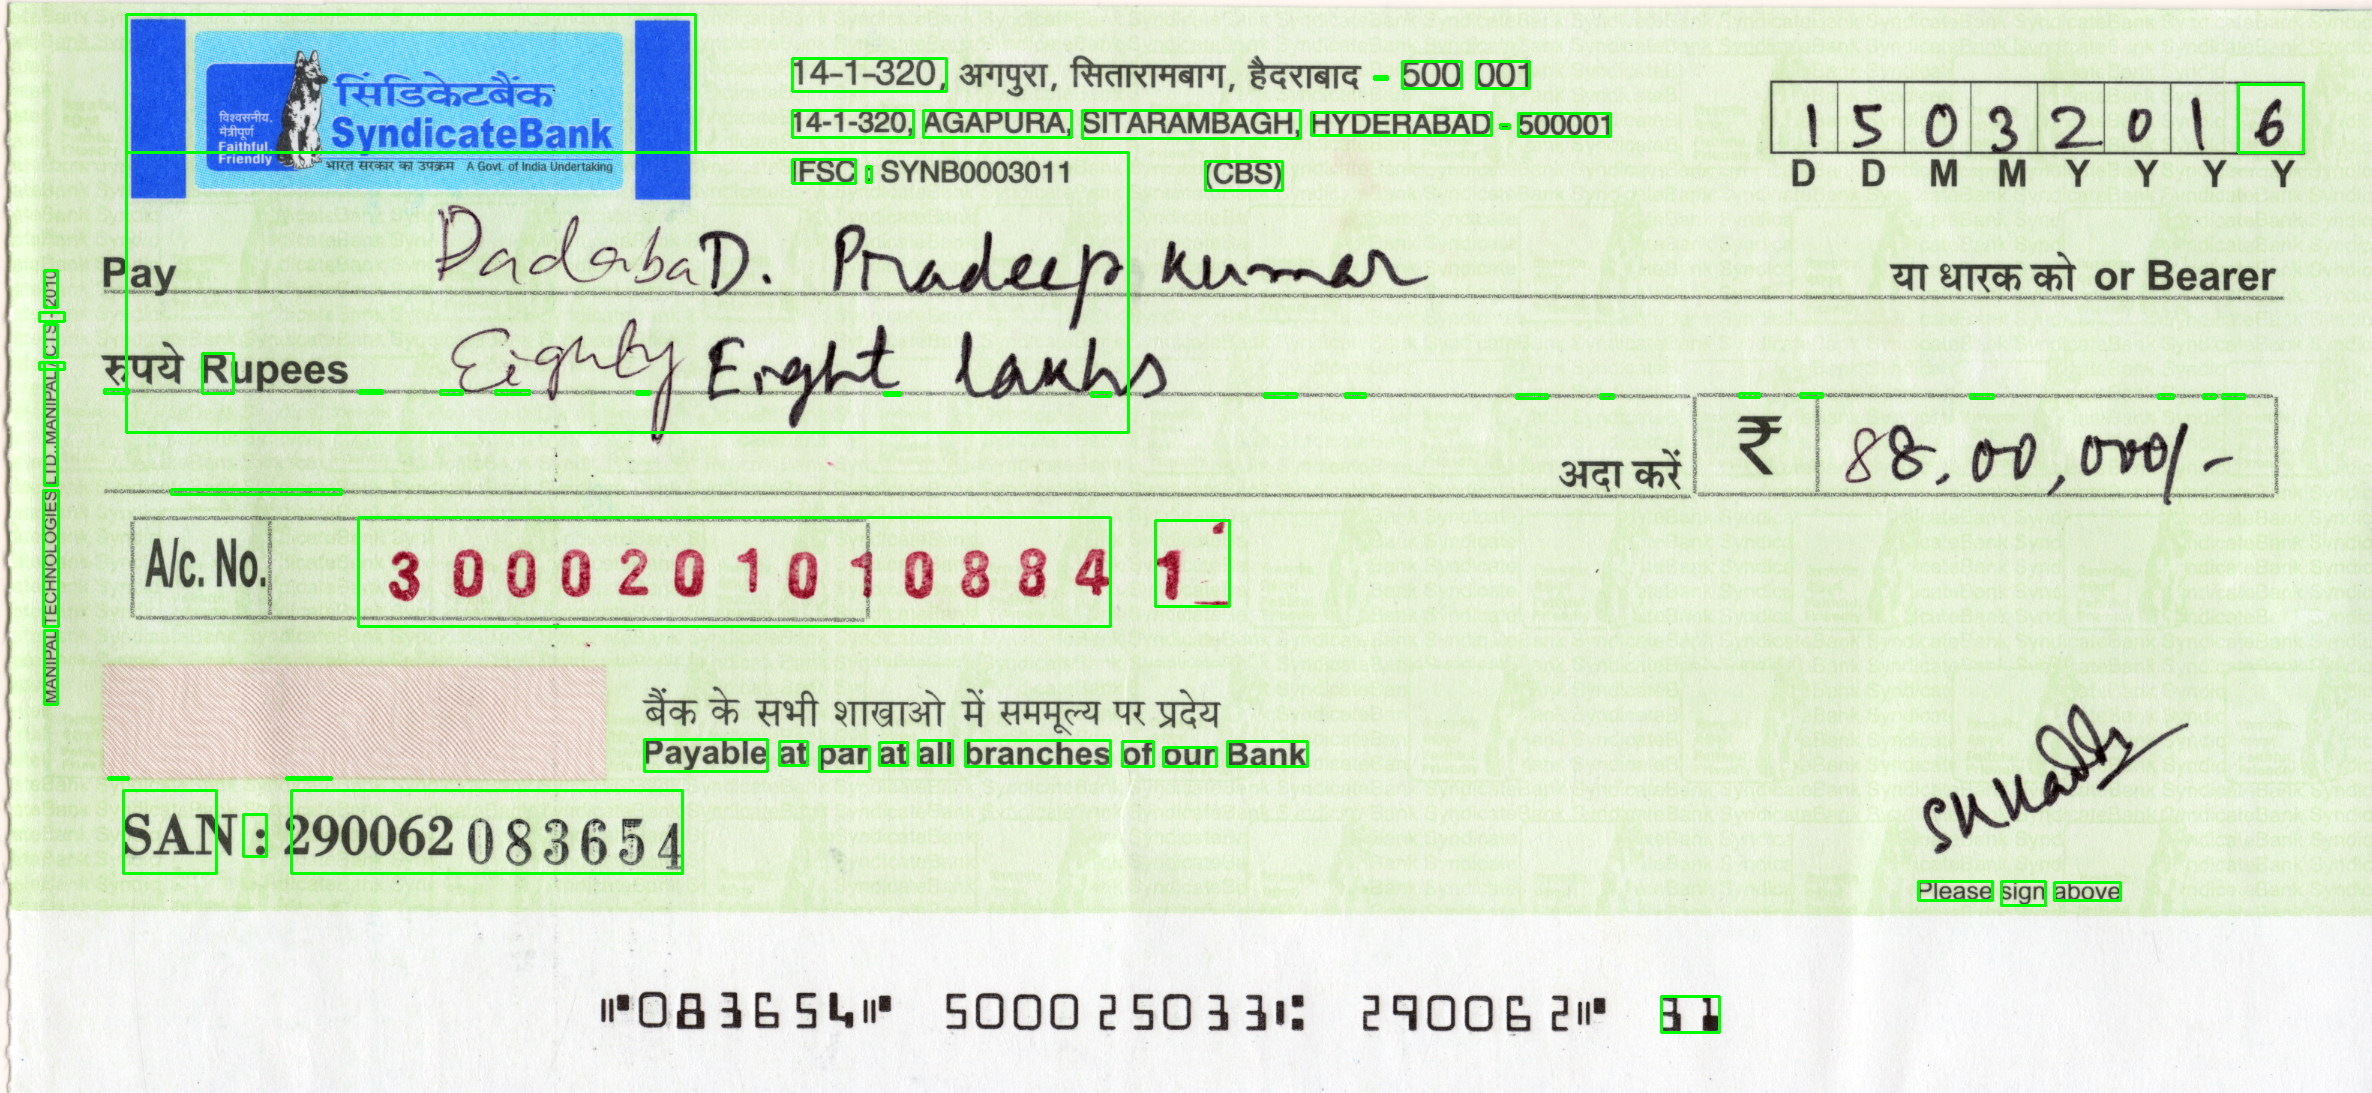

In [15]:
Image.fromarray(img_boite)

### Extraire le montant 

In [22]:
custom_config = r'--oem 3 --psm 6'

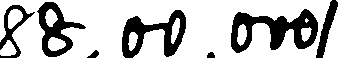

In [16]:
mount = thresh[int(thresh.shape[0]/2.58):int(thresh.shape[0]/2.27), int(thresh.shape[1]/1.282):int(thresh.shape[1]/1.078)]
Image.fromarray(mount)

In [17]:
mount.shape

(58, 350)

()

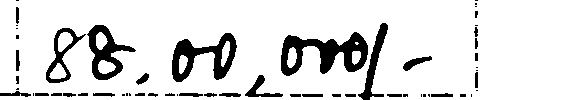

In [29]:

Image.fromarray(check_img)